In [ ]:
!pip show ffmpeg

""

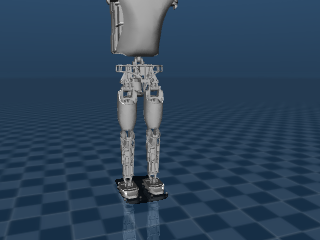

[ 0.00000000e+00 -1.32922125e+03  4.75001438e+01  4.71282228e+01
  1.07742695e+00  2.77539615e+00 -6.82628850e-01 -6.38336700e-01
  2.77539615e+00 -6.82628850e-01 -6.38336700e-01]


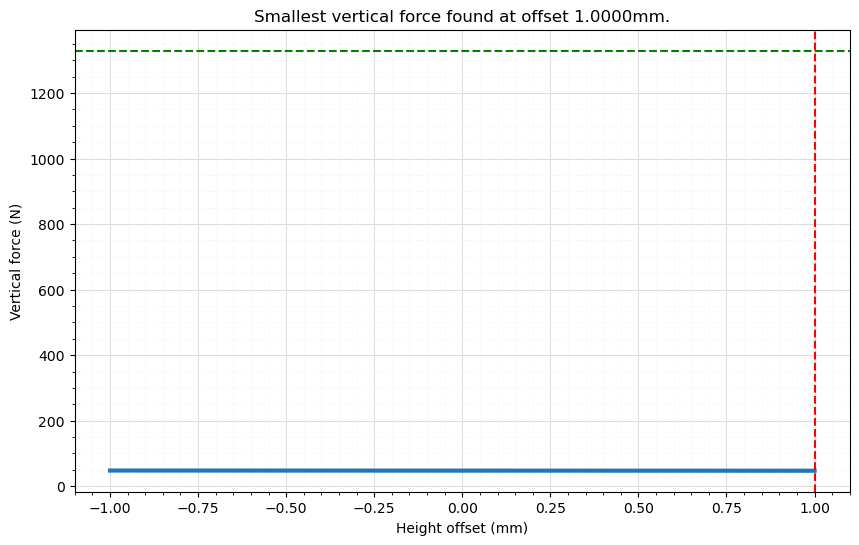

desired forces: [ 0.00000000e+00 -1.32922125e+03  4.71843359e+01  4.68092173e+01
  1.07689254e+00  2.83852294e+00 -6.62267416e-01 -6.36752360e-01
  2.83852294e+00 -6.62267416e-01 -6.36752360e-01]
control setpoint: [46.80921726  1.07689254  2.83852294 -0.66226742 -0.63675236  2.83852294
 -0.66226742 -0.63675236]
actuator forces: [ 0.          0.          0.         46.80921726  1.07689254  2.83852294
 -0.66226742 -0.63675236  2.83852294 -0.66226742 -0.63675236]


In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np

with open('scene.xml', 'r') as f:
    xml = f.read()
    
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())
  
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    # camera.lookat = data.body('torso').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

actuator_moment = np.zeros((model.nu, model.nv))
mujoco.mju_sparse2dense(
    actuator_moment,
    data.actuator_moment.reshape(-1),
    data.moment_rownnz,
    data.moment_rowadr,
    data.moment_colind.reshape(-1),
)
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    # camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)

nv = model.nv  # Shortcut for the number of DoFs.